In [1]:
# Using the WTI dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from IPython.display import clear_output

In [2]:
# Importing the Decompositions and approximated sets

#importing the original data
crude =  pd.read_csv('crude.csv')
crude['Date'] = pd.to_datetime(crude['Date'], format='%Y-%m-%d')
crude.set_index(crude['Date'], inplace=True)
crude.drop('Date', axis=1, inplace=True)
crude = crude['2007-02-01':'2015-10-21']
crude.dropna(inplace=True)

#includes the decompositions of level 1-5
decomp= pd.read_csv('Decomp.csv')  

#only importing the approximation of level 5
approx = pd.read_csv('Approx.csv')
approx = approx.transpose().reset_index()
approx = approx[3]
approx = pd.DataFrame(approx.values,columns=['A5'])

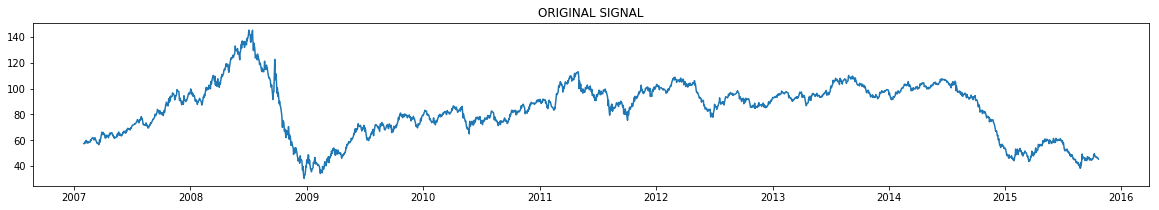

In [3]:
plt.figure(figsize=(20,3))
plt.plot(crude.index, crude.demand)
plt.title('ORIGINAL SIGNAL')
plt.show()

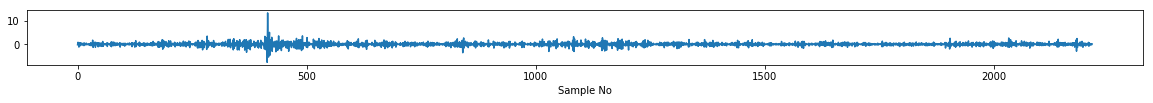

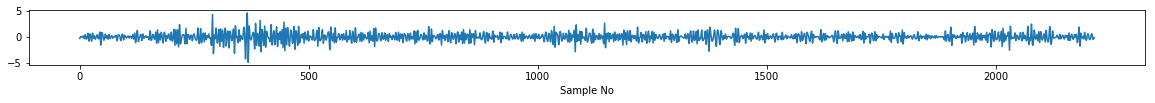

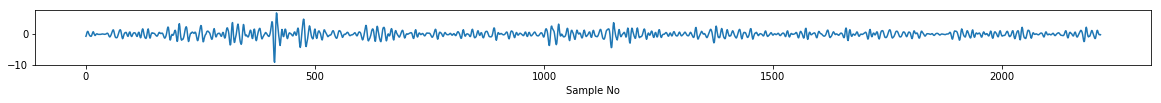

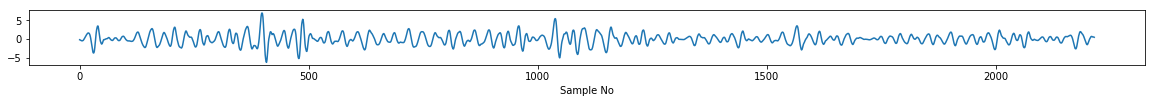

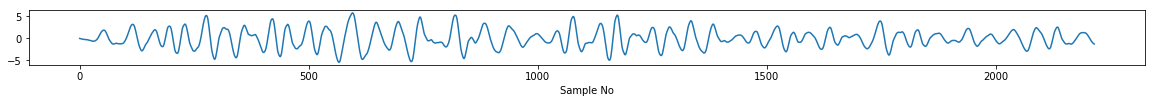

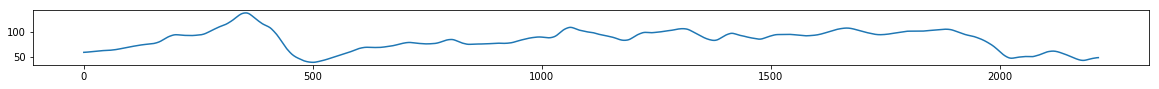

In [4]:
for i in decomp.columns:
    plt.figure(figsize=(20,1))
    plt.plot(decomp[i])
    plt.xlabel('Sample No')

# plt.title('DETAILED SIGNAL')
plt.figure(figsize=(20,1))
plt.plot(approx.values)
plt.show()

In [5]:
# Defining the Morlet Wavelet Function
def Morlet(z):
    return tf.multiply(tf.cos(tf.multiply(tf.constant(1.75), z)),tf.exp(tf.multiply(tf.pow(z,2), tf.constant(-0.5))))

# Defining the Mexican Hat Wavelet Function
def Mexican(z):
    return tf.multiply(tf.subtract(tf.constant(1.0), tf.pow(z,2)), tf.exp(tf.multiply(tf.constant(-0.5), tf.pow(z,2))))

In [6]:
def new_weights(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=1, seed=42),name = name)

In [7]:
n_hidden = 10                
n_class = 1
lr = 0.005        #Learning rate
alpha = 1
batch_size = 3
n_features = 1

In [8]:
# Input and target Placeholders
x = tf.placeholder(tf.float32, [None, n_features], name = 'X_label')      # n X 6
y = tf.placeholder(tf.float32, [None, n_class], name = 'y_label')

In [9]:
X_train = decomp.copy()
X_train['A5'] = approx.values
X_train_no = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
X_train_no = X_train_no.values

In [10]:
def Predictor(da, num_iterations):

    X_train_norm = X_train_no.T[da].reshape([X_train.shape[0],1])
    n_features = X_train_norm.shape[1]
    
    
    #Defining the various weights in Tesorflow graph

    W_inphid = new_weights([n_hidden, n_features], 'wij')   # 10 X 1
    W_trans = new_weights([n_hidden, 1], 'bj')              # 10 X 1
    W_dilat = new_weights([n_hidden, 1],'aj')               # 10 X 1
    W_hidout = new_weights([n_class, n_hidden], 'cj')       # 1 X 10
    W_rec = new_weights([n_class, n_hidden], 'vj')          # 1 X 10
#     W_inout = new_weights([n_class, n_features], 'ioj')          # 1 X 10

    biases = tf.Variable(tf.constant(0.01, shape=[1]))
    
    
    # Initial Values of recurrent part
    u = tf.random_normal(shape=[10,1], mean=0,stddev=0.2, seed=42)     # 10 X 1
    # u = tf.zeros(shape=[10,1])     # 10 X 1

    # Net input to Hidden Layer
    net_hidd = tf.add(tf.divide(tf.subtract(tf.matmul(W_inphid, tf.transpose(x)), W_trans),W_dilat), 0)#tf.multiply(tf.transpose(W_rec), u))   # 10 X ?

    # Output of Hidden Layer
    out_hidd = Morlet(net_hidd)

    # Final Output
    out = tf.matmul(W_hidout,out_hidd) + biases   # 1 X ?

    # Cost
    cost = tf.reduce_mean(tf.square(out-y))

    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
    
    
    x_train = np.roll(X_train_norm, 1)
    # Y_train = (Y_train - min(approx.values))/(max(approx.values) - min(approx.values))
    x_train = x_train.reshape(2216)
    Y_train = X_train_norm
    # x_train = (X_train - min(approx.values))/(max(approx.values) - min(approx.values))
    Y_train = Y_train.reshape(2216)
    
    
    n_examp = X_train.shape[0]
    x_train = tf.data.Dataset.from_tensor_slices(x_train)
    Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
    # zip the two datasets together
    dcomb = tf.data.Dataset.zip((x_train, Y_train)).batch(batch_size)
    iterator = dcomb.make_initializable_iterator()
    # extract an element
    next_element = iterator.get_next()
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    costy=[]
    sess.run(iterator.initializer)
    print('Epoch :', end='')
    for j in range(num_iterations):
        print(j+1,end =' ')
        i=1
        sess.run(iterator.initializer)
        tot_cost = 0
        while(i):
            try:
                val = sess.run(next_element)
                val = np.array(val)
                feed_dict_train = {x:val[0].reshape(batch_size,1), y:val[1].reshape(batch_size,1)}
                _, cos = sess.run([optimizer, cost] ,feed_dict=feed_dict_train)
                tot_cost += cos
            except:
                i=0
                continue
        costy.append(tot_cost)
        
    # Predicting the values
    feed_dict_train = {x:X_train_norm}
    pred = sess.run(out, feed_dict=feed_dict_train)
        
    return costy, pred

Epoch :1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

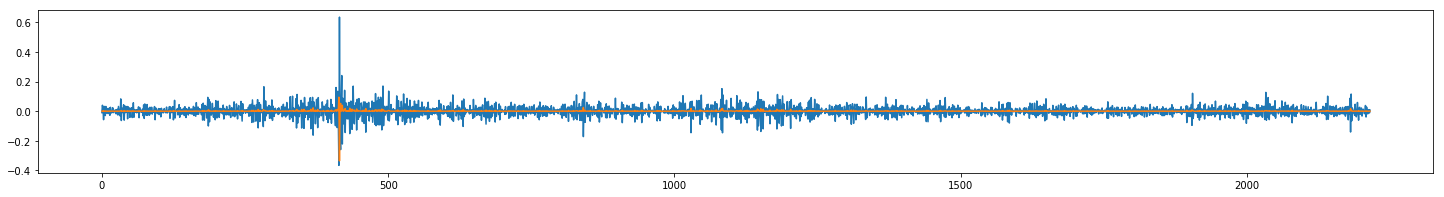

Epoch :1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

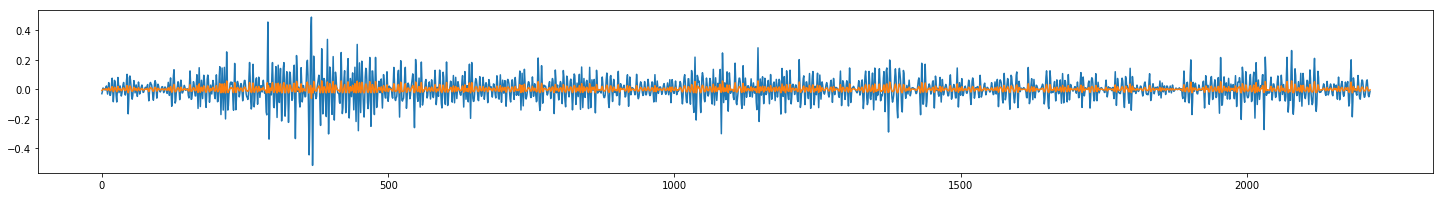

Epoch :1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

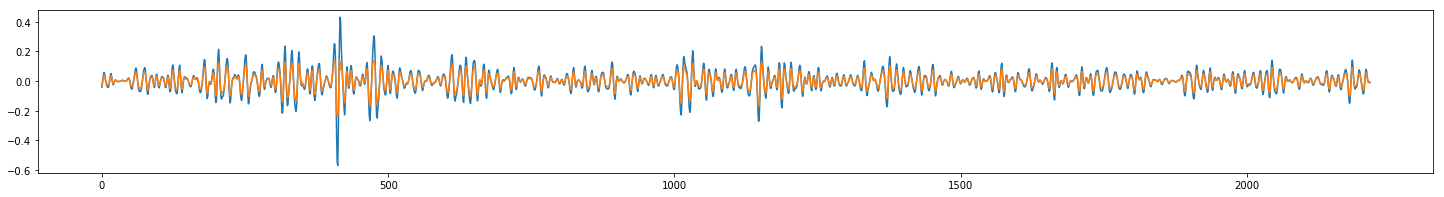

Epoch :1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

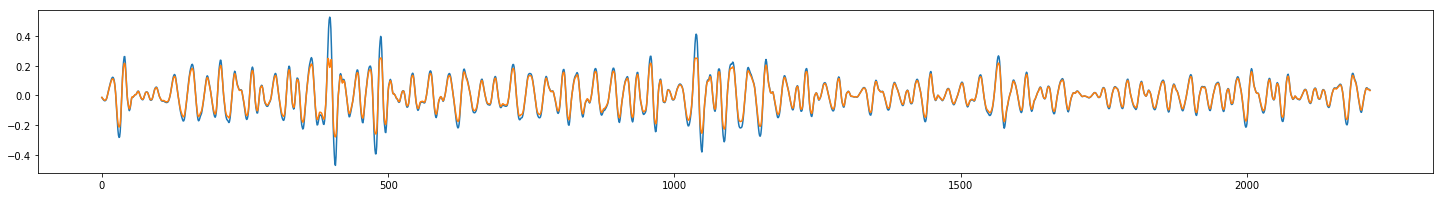

Epoch :1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

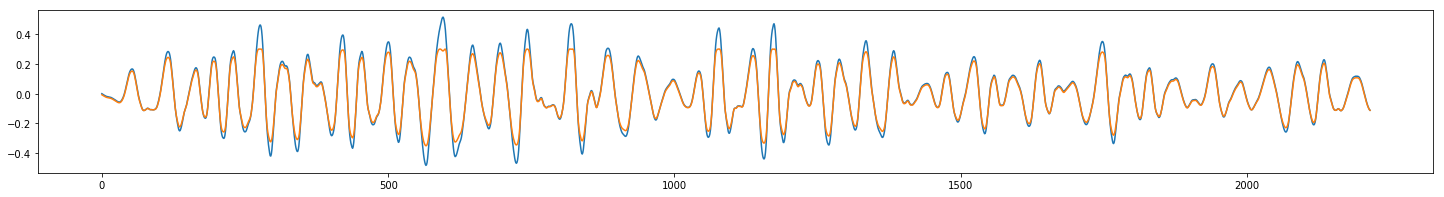

Epoch :1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

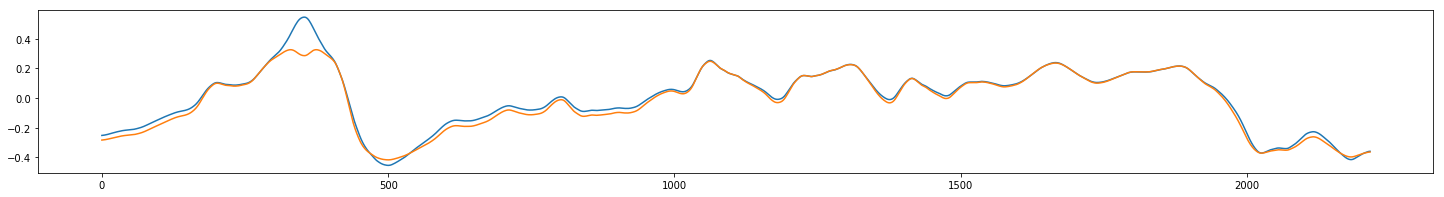

In [11]:
predy = []
for i in range(6):
    costy, pred = Predictor(i, num_iterations=20)
    predy.append(pred)
    plt.figure(figsize=[25,3])
    plt.plot(X_train_no.T[i])
    plt.plot(pred[0])
    plt.show()

In [12]:
predy = np.array(predy)
predy1 = predy.reshape([6,2216])
predy2 = (predy1.T*(np.array((X_train.max() - X_train.min())).reshape([1,6])) + np.array(X_train.mean()).reshape([1,6])).T
aggr = predy2.sum(axis=0)
aggr = aggr

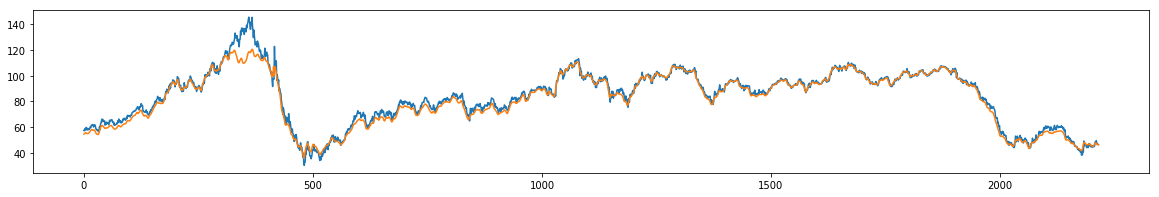

In [13]:
plt.figure(figsize=(20,3))
plt.plot(crude.demand.values[0:2216])
plt.plot(aggr)
plt.show()

In [14]:
# Difining the Various accuracy measures
crude = crude[0:2216]
# Mean absolute error
n_examp = X_train.shape[0]
# MAPE
MAPE = 1/n_examp*sum(abs(crude.values.T[0]-aggr)/abs(crude.values.T[0]))*100

# S-MAPE
SMAPE = 2/n_examp*sum(abs(crude.values.T[0]-aggr)/(abs(crude.values.T[0]) + abs(aggr)))*100

# TIC
TIC = np.sqrt(1/n_examp*sum((crude.values.T[0]-aggr)**2))/(np.sqrt(1/n_examp*sum((crude.values.T[0])**2)) + np.sqrt(1/n_examp*sum((aggr)**2)))

# R
R= sum(((crude.values.T[0] - crude.values.T[0].mean())*(aggr - aggr.mean())))/(np.sqrt(np.sum((crude.values.T[0] - crude.values.T[0].mean())**2)*np.sum((aggr - aggr.mean())**2)))


In [15]:
sc_name = ['MAPE','SMAPE', 'TIC','R']
scores =[MAPE, SMAPE, TIC,R]


for nam,sc in zip(sc_name,scores):
    print(nam, ' :',sc)

MAPE  : 2.9790358532016685
SMAPE  : 3.0418710816109007
TIC  : 0.022765842665023232
R  : 0.9862365522256825


In [ ]:
'''
MAPE  : 2.9790358532016685
SMAPE  : 3.0418710816109007
TIC  : 0.022765842665023232
R  : 0.9862365522256825
'''